In [1]:
# Loading
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
%matplotlib inline

# 1 User input

## 1.1 Input and format cluster analysis results

Enter normalised medoid data

In [2]:
normmedoidobjdf = pd.read_pickle("Data/normmedoidobjdf")

Create chart formatted titles

In [3]:
# have hacked names to appear nicely on radar chart
obj1name = 'Minimum Storage'
obj2name = 'Total Cost                '
obj3name = '               Total Spill'

objnames = [obj1name, obj2name, obj3name]

## 1.2 Input and format shortlist of decision options 

Input shortlist normalised objective function performance

In [4]:
normshortlistobjdf = pd.read_pickle("Data/normshortlistobjdf")

## 1.3 Specify cluster colours

Enter cluster colour pool. This is shared with other plots.

In [5]:
clustcols = pd.read_pickle("Data/clustercolours")

## 1.4 Specify number of rows and columns for diagrams

Function dimensions creates a list showing dimensions (rows and columns) of subplots, for a given number of plots. Columns is given the greater of two dimensions, where relevant.

In [6]:
def dimensions(numplots):
    rows = int(numplots**0.5) + (numplots % numplots**0.5 > 0) # rounds up the square root of numplots
    cols = int(numplots/rows) + (numplots % rows > 0) # rounds up the numplots divided by num cols
    return [rows, cols]

In [7]:
medrow = dimensions(len(normmedoidobjdf.index))[0]
medcol = dimensions(len(normmedoidobjdf.index))[1]

In [8]:
shortcol = dimensions(len(normshortlistobjdf.index))[1]
shortrow = dimensions(len(normshortlistobjdf.index))[0]

# 2 Define functions

## 2.1 Radar chart projection function

Source: http://matplotlib.org/examples/api/radar_chart.html

Note: this function takes a dict such as 
{'column names': ['Variable 1', 'Variable 2'], 'Option 1': [var1, var2], 'Option 2': [var1, var2]}

In [9]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = 2*np.pi * np.linspace(0, 1-1./num_vars, num_vars)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180/np.pi, labels, frac = 1.1)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta

In [10]:
def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

# 3 Execution

## 3.1 Create spider diagram of cluster medoids

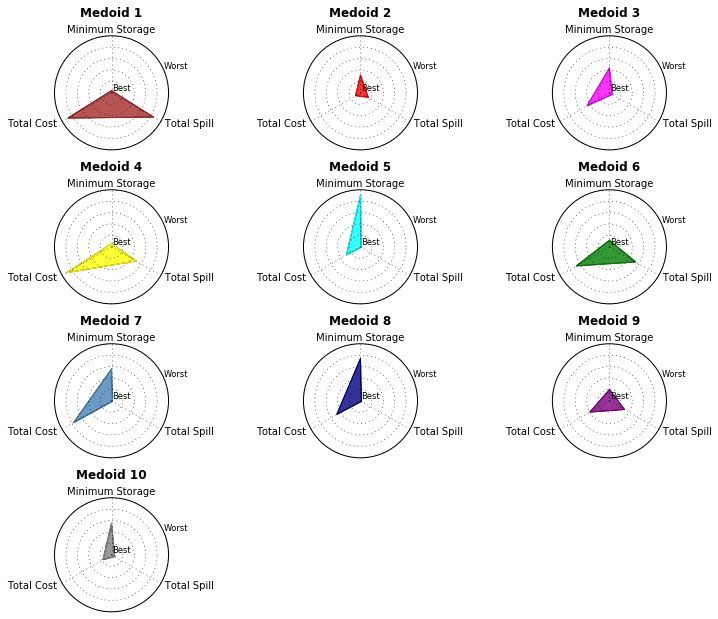

In [11]:
N = len(objnames) # number of axes
theta = radar_factory(N, frame='circle')

spoke_labels = objnames

fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(wspace=0.45, hspace=0.35, top=0.85, bottom=0.05)

for i in normmedoidobjdf.index:
    ax = fig.add_subplot(medrow, medcol, i+1, projection='radar')
    plt.rgrids((0.01, 0.2, 0.4, 0.6, 0.8, 1.0), labels = ('Best','','','','','Worst'),
              size = 'small')
    plt.ylim([0,1.0])
    medname = 'Medoid %d' % (normmedoidobjdf.index[i]+1)
    ax.set_title(medname, weight='bold', position=(0.5, 1.15),
                 horizontalalignment='center', verticalalignment='center')
    ax.plot(theta, normmedoidobjdf.ix[i], color=clustcols[i])
    ax.fill(theta, normmedoidobjdf.ix[i], facecolor=clustcols[i], alpha=0.8)
    ax.set_varlabels(spoke_labels)

# save and close figure
plt.savefig('Spider Diagram/spider diagrams.png', dpi = 150, bbox_inches = 'tight')

In [12]:
plt.close(fig)

## 3.2 Create spider diagram of shortlist

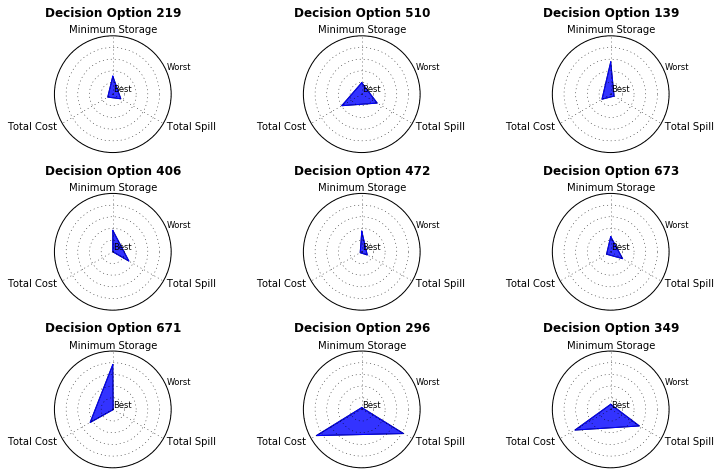

In [13]:
N = len(objnames) # number of axes
theta = radar_factory(N, frame='circle')

data = normshortlistobjdf
spoke_labels = objnames

fig = plt.figure(figsize=(12, 7.5))
fig.subplots_adjust(wspace=0.45, hspace=0.35, top=0.85, bottom=0.05)

for i in range(0, len(data)):
    ax = fig.add_subplot(shortrow, shortcol, i+1, projection='radar')
    plt.rgrids((0.01, 0.2, 0.4, 0.6, 0.8, 1.0), labels = ('Best','','','','','Worst'),
              size = 'small')
    plt.ylim([0,1.0])
    shortname = 'Decision Option %s' % (data.index[i]+1)
    ax.set_title(shortname, weight='bold', position=(0.5, 1.15),
                 horizontalalignment='center', verticalalignment='center')
    ax.plot(theta, data.ix[data.index[i]])
    ax.fill(theta, data.ix[data.index[i]], alpha=0.8)
    ax.set_varlabels(spoke_labels)

# save and close figure
plt.savefig('Spider Diagram/spider diagrams shortlist.png', dpi = 150, bbox_inches = 'tight')

In [14]:
plt.close(fig)